# Sentiment analysis on flipkart product reviews.
## Dataset: <a href='https://www.kaggle.com/datasets/gitadityamaddali/flipkart-laptop-reviews'>Click here</a>

## Column description:
<ul>
    <li>product_name – Name and specifications of the laptop.</li>
    <li>overall_rating – Average rating of the product.</li>
    <li>no_ratings – Total number of ratings received.</li>
    <li>no_reviews – Total number of reviews written.</li>
    <li>rating – Individual rating given by the user (out of 5).</li>
    <li>title – Short summary of the review.</li>
    <li>review – Full text of the customer’s review.</li>
</ul>

# Importing necessary libraries

In [ ]:
import polars
import seaborn
import matplotlib.pyplot as mplot

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, classification_report

In [2]:
dataset = polars.read_csv('laptops_dataset_final_600.csv')
dataset.head()

product_name,overall_rating,no_ratings,no_reviews,rating,title,review
str,f64,i64,i64,i64,str,str
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Perfect product!""","""Loved it, it's my first MacBoo…"
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Fabulous!""","""Battery lasted longer than my …"
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Fabulous!""","""Such a great deal.. very happy…"
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,4,"""Delightful""","""Awesome build quality and very…"
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Awesome""","""When i ordered and came to kno…"


In [3]:
dataset.shape

(24113, 7)

# Checking for missing values

In [4]:
dataset.null_count()

product_name,overall_rating,no_ratings,no_reviews,rating,title,review
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0


# Visualizing the dataset
##### Performing this to check for any class imbalance if present, and if so then how to remove it
## Overall Rating column

<Axes: title={'center': 'Overall rating distribution of the products'}, xlabel='overall_rating', ylabel='count'>

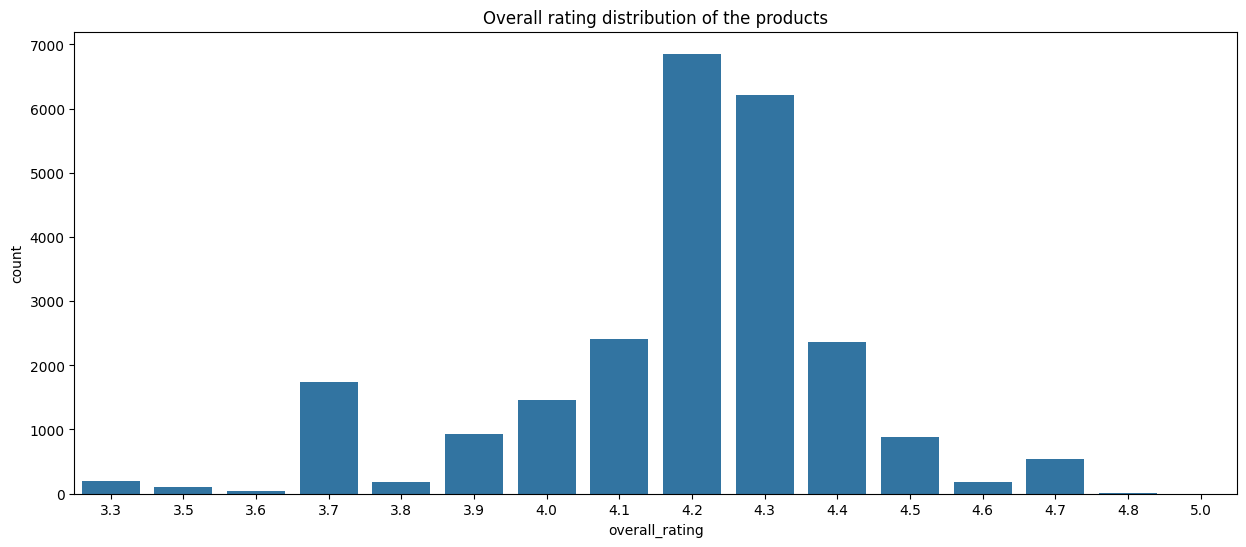

In [5]:
mplot.figure(figsize=(15, 6))
mplot.title('Overall rating distribution of the products')
seaborn.barplot(data=dataset['overall_rating'].value_counts(), x='overall_rating', y='count')

#### Findings:
<ul>
    <li>The concentration of values is around 4.1 - 4.5</li>
    <li>If downsampling is performed then the rating scale must be adjusted in this particular rating frame</li>
</ul>

## Rating column

<Axes: title={'center': "User's individual rating distribution"}, xlabel='rating', ylabel='count'>

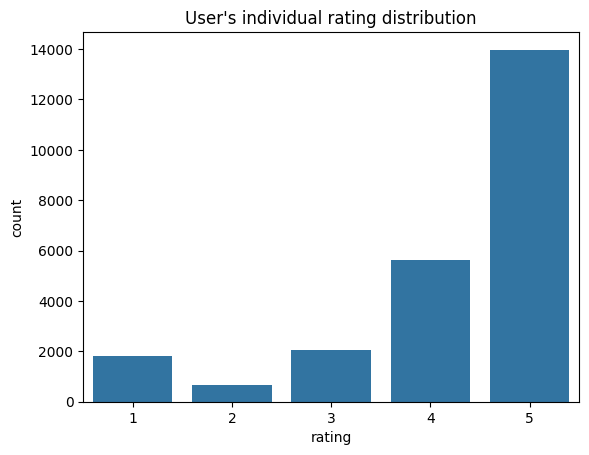

In [6]:
mplot.title("User's individual rating distribution")
seaborn.barplot(data=dataset['rating'].value_counts(), x='rating', y='count')

#### Findings:
<ul>
    <li>Heavy class imbalance.</li>
    <li>To reduce imbalance we need to perform the following:</li>
    <ul>
        <li>Downsample heavily imbalanced class</li>
        <li>Upsample minority class using SMOTE technique</li>
        <li>Stratifying Train Test Split</li>
    </ul>
</ul>

In [7]:
dataset['rating'].value_counts()

rating,count
i64,u32
2,668
1,1809
3,2035
5,13972
4,5629


# Addressing class imbalance issue
## Downsampling the higher class data

In [8]:
dataset.shape

(24113, 7)

### For rating == 5
#### Procedure:
<ul>
    <li>Considering the no_ratings columns as most people do not leave reviews but rather provide the ratings for products</li>
    <li>Finding the inter-quartile range of no-ratings</li>
    <li>Using the last quartile, i.e., >75% of the data where: rating = 5</li>
    <li>Using the reviews who has a overall_rating >= 4</li>
</ul>

In [9]:
dataset.filter(polars.col('rating') == 5)['no_ratings'].quantile(0.75)

3767.0

In [10]:
dataset = dataset.filter(~(
    (polars.col('rating') == 5)
    &
    (polars.col('no_ratings') <= 3767)
))
dataset.shape

(13471, 7)

In [11]:
dataset = dataset.filter(~(
    (polars.col('rating') == 5)
    &
    (polars.col('overall_rating') < 4.0)
))
dataset.shape

(13331, 7)

In [12]:
dataset.filter(polars.col('rating') == 5)['no_reviews'].mean()

582.7031347962383

In [13]:
min(dataset.filter(polars.col('rating') == 5)['no_reviews'])

272

In [14]:
dataset = dataset.filter(~(
    (polars.col('rating') == 5)
    &
    (polars.col('no_reviews') < 581)
))
dataset.shape

(11237, 7)

### For rating == 4
##### Following the same procedure

In [15]:
dataset.filter(polars.col('rating') == 4)['no_ratings'].quantile(0.75)

4134.0

In [16]:
dataset.filter(polars.col('rating') == 4).shape

(5629, 7)

In [17]:
dataset = dataset.filter(~(
    (polars.col('rating') == 4)
    &
    (polars.col('no_ratings') <= 4134)
))
dataset.shape

(6990, 7)

In [18]:
dataset = dataset.filter(~(
    (polars.col('rating') == 4)
    &
    (polars.col('overall_rating') < 4.0)
))
dataset.shape

(6948, 7)

In [19]:
dataset.filter(polars.col('rating') == 4)['no_reviews'].mean()

559.6208955223881

In [20]:
min(dataset.filter(polars.col('rating') == 4)['no_reviews'])

272

In [21]:
dataset = dataset.filter(~(
    (polars.col('rating') == 4)
    &
    (polars.col('no_reviews') < 558)
))
dataset.shape

(6144, 7)

# Adding sentiment column
##### Adding the sentiment column based on the per user ratings, 0-2: negative 3: neutral and 4-5 will be positive.

In [22]:
dataset.head()

product_name,overall_rating,no_ratings,no_reviews,rating,title,review
str,f64,i64,i64,i64,str,str
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Perfect product!""","""Loved it, it's my first MacBoo…"
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Fabulous!""","""Battery lasted longer than my …"
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Fabulous!""","""Such a great deal.. very happy…"
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,4,"""Delightful""","""Awesome build quality and very…"
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Awesome""","""When i ordered and came to kno…"


In [23]:
dataset = dataset.with_columns(
    polars.when((polars.col('rating') == 5) | (polars.col('rating') == 4)).then(polars.lit('positive'))
    .when(polars.col('rating') == 3).then(polars.lit('neutral'))
    .otherwise(polars.lit('negative'))
    .alias('sentiment')
)
dataset.head()

product_name,overall_rating,no_ratings,no_reviews,rating,title,review,sentiment
str,f64,i64,i64,i64,str,str,str
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Perfect product!""","""Loved it, it's my first MacBoo…","""positive"""
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Fabulous!""","""Battery lasted longer than my …","""positive"""
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Fabulous!""","""Such a great deal.. very happy…","""positive"""
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,4,"""Delightful""","""Awesome build quality and very…","""positive"""
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Awesome""","""When i ordered and came to kno…","""positive"""


In [24]:
dataset = dataset.with_columns(
    (polars.col('title') + ' ' + polars.col('review')).alias('reviews')
)
dataset.head()

product_name,overall_rating,no_ratings,no_reviews,rating,title,review,sentiment,reviews
str,f64,i64,i64,i64,str,str,str,str
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Perfect product!""","""Loved it, it's my first MacBoo…","""positive""","""Perfect product! Loved it, it'…"
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Fabulous!""","""Battery lasted longer than my …","""positive""","""Fabulous! Battery lasted longe…"
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Fabulous!""","""Such a great deal.. very happy…","""positive""","""Fabulous! Such a great deal.. …"
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,4,"""Delightful""","""Awesome build quality and very…","""positive""","""Delightful Awesome build quali…"
"""Apple MacBook AIR Apple M2 - (…",4.7,15210,900,5,"""Awesome""","""When i ordered and came to kno…","""positive""","""Awesome When i ordered and cam…"


<Axes: title={'center': 'Sentiment distribution'}, xlabel='sentiment', ylabel='count'>

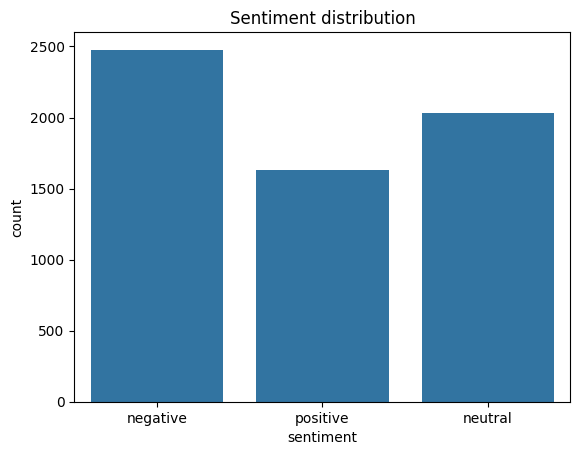

In [25]:
mplot.title('Sentiment distribution')
seaborn.barplot(data=dataset['sentiment'].value_counts(), x='sentiment', y='count')

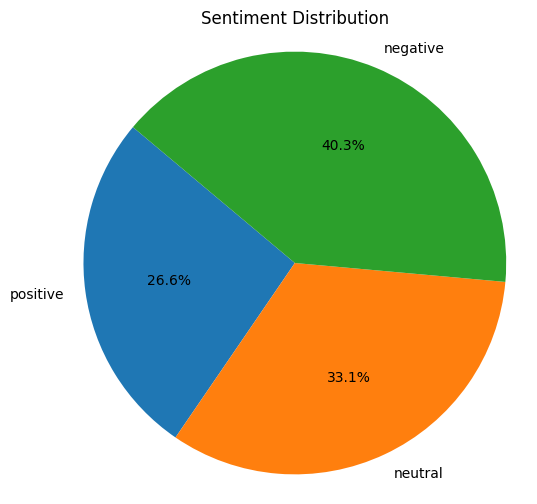

In [26]:
sentiment_counts = dataset['sentiment'].value_counts().to_dict(as_series=False)

labels = list(sentiment_counts['sentiment'])
sizes = list(sentiment_counts['count'])

mplot.figure(figsize=(6, 6))
mplot.title('Sentiment Distribution')
mplot.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
mplot.axis('equal')
mplot.show()

In [27]:
dataset = dataset.drop(['product_name', 'overall_rating', 'no_ratings', 'no_reviews', 'title', 'review',])
dataset.columns

['rating', 'sentiment', 'reviews']

In [28]:
dataset = polars.concat([dataset[:, 0:1], dataset[:, -1:], dataset[:, 1:2]], how='horizontal')
dataset.head()

rating,reviews,sentiment
i64,str,str
5,"""Perfect product! Loved it, it'…","""positive"""
5,"""Fabulous! Battery lasted longe…","""positive"""
5,"""Fabulous! Such a great deal.. …","""positive"""
4,"""Delightful Awesome build quali…","""positive"""
5,"""Awesome When i ordered and cam…","""positive"""


In [29]:
dataset.write_csv('reduced reviews.csv')

In [30]:
dataset = polars.read_csv('reduced reviews.csv')
dataset.head()

rating,reviews,sentiment
i64,str,str
5,"""Perfect product! Loved it, it'…","""positive"""
5,"""Fabulous! Battery lasted longe…","""positive"""
5,"""Fabulous! Such a great deal.. …","""positive"""
4,"""Delightful Awesome build quali…","""positive"""
5,"""Awesome When i ordered and cam…","""positive"""


# Preprocessing texts
## Removing punctuations and emojis

In [31]:
emoji_pattern = re.compile(
    r"["
    r"\U0001F600-\U0001F64F"  # emoticons
    r"\U0001F300-\U0001F5FF"  # symbols & pictographs
    r"\U0001F680-\U0001F6FF"  # transport & map symbols
    r"\U0001F700-\U0001F77F"  # alchemical symbols
    r"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    r"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    r"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    r"\U0001FA00-\U0001FA6F"  # Chess symbols
    r"\U0001FA70-\U0001FAFF"  # Symbols and pictographs extended
    r"\U00002702-\U000027B0"  # Dingbats
    r"\U000024C2-\U0001F251"  # Enclosed characters
    r"\U0001F004-\U0001F0CF"  # Playing cards
    r"\U0001F170-\U0001F251"  # Miscellaneous symbols
    r"]", flags=re.UNICODE
)

In [32]:
# For emojis
def remove_emojis(text: str) -> str:
    return re.sub(emoji_pattern, '', text)

dataset = dataset.with_columns(
    polars.col('reviews').
    map_elements(
        function=lambda r: remove_emojis(r),
        return_dtype=polars.String
    ).alias('cleaned reviews')
)

In [33]:
print(f'Original reviews: {dataset[0, 'reviews']}')
print(f'Cleaned reviews: {dataset[0, 'cleaned reviews']}')

Original reviews: Perfect product! Loved it, it's my first MacBook that I earned from my hardwork 🥺❤️
Cleaned reviews: Perfect product! Loved it, it's my first MacBook that I earned from my hardwork 


In [34]:
# For punctuations
def remove_punctuation(text: str) -> str:
    return text.translate(str.maketrans('', '', string.punctuation))

dataset = dataset.with_columns(
    polars.col('cleaned reviews').
    map_elements(
        function=lambda p: remove_punctuation(p),
        return_dtype=polars.String
    ).alias('cleaned reviews')
)

In [35]:
print(f'Original reviews: {dataset[0, 'reviews']}')
print(f'Cleaned reviews: {dataset[0, 'cleaned reviews']}')

Original reviews: Perfect product! Loved it, it's my first MacBook that I earned from my hardwork 🥺❤️
Cleaned reviews: Perfect product Loved it its my first MacBook that I earned from my hardwork 


## Removing stopwords and converting the texts to lowercase

In [36]:
stop_words = set(stopwords.words('english'))

def remove_stopwords_to_lower(text):
    text = text.lower()

    # Tokenizing the text and removing stopwords
    tokens = text.split()
    filtered = [word for word in tokens if word not in stop_words]

    # Reconstructing the cleaned text
    return ' '.join(filtered)

dataset = dataset.with_columns(
    polars.col('cleaned reviews').
    map_elements(
        function=lambda sl: remove_stopwords_to_lower(sl),
        return_dtype=polars.String
    ).alias('cleaned reviews')
)

In [37]:
print(f'Original reviews: {dataset[0, 'reviews']}')
print(f'Cleaned reviews: {dataset[0, 'cleaned reviews']}')

Original reviews: Perfect product! Loved it, it's my first MacBook that I earned from my hardwork 🥺❤️
Cleaned reviews: perfect product loved first macbook earned hardwork


In [38]:
dataset.write_csv('cleaned reviews.csv')

## Performing Lemmatization

In [2]:
dataset = polars.read_csv('cleaned reviews.csv')

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

In [12]:
lemmatizer = WordNetLemmatizer()

In [13]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun

In [14]:
def pos_lemmatizing_texts(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    
    lemmatized_tokens = []
    for word, pos_tagging in tagged_tokens:
        lemmatized_tokens.append(lemmatizer.lemmatize(word, get_wordnet_pos(pos_tagging)))
        
    if len(lemmatized_tokens) > 0:
        return ' '.join(lemmatized_tokens)
    else:
        return text


In [15]:
dataset = dataset.with_columns(
    polars.col('cleaned reviews').
    map_elements(
        lambda lm: pos_lemmatizing_texts(lm), 
        return_dtype=polars.Utf8
    ).alias('lemmatized reviews')
)

In [16]:
print(f'Original reviews: {dataset[0, 'cleaned reviews']}')
print(f'Cleaned reviews: {dataset[0, 'lemmatized reviews']}')

Original reviews: perfect product loved first macbook earned hardwork
Cleaned reviews: perfect product love first macbook earn hardwork


# Dataset Splitting
##### The dataset is splitted into train, validation and test sets so that there is no data leakage, while encoding the dataset

In [71]:
xtrain, xtest, ytrain, ytest = train_test_split(
    dataset['lemmatized reviews'], dataset['sentiment'],
    test_size=0.1,
    random_state=42,
    stratify=dataset['sentiment']
)

In [43]:
xtrain.head(2)

lemmatized reviews
str
"""classy product first time use …"
"""awesome 5 day usage surely say…"


In [44]:
ytrain.head(2)

sentiment
str
"""positive"""
"""positive"""


# Word Vectorizing
<ul>
    <li>Using TF_IDF to vectorize the texts</li>
    <li>Using unigram and bigram extraction</li>
    <li>This is done by using ngram_range parameter</li>
</ul>

In [72]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer.fit(xtrain)

TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

In [73]:
xtrain_vec = vectorizer.transform(xtrain)
xtest_vec = vectorizer.transform(xtest)

# Encoding target variable
##### Label Encoding for linear models and one Hot encoding for Hybrid models

In [74]:
LE = LabelEncoder()
LE.fit(ytrain)

LabelEncoder()

In [75]:
ytrain_LE = LE.transform(ytrain)
ytest_LE = LE.transform(ytest)

In [76]:
ytrain_LE

array([2, 2, 0, ..., 0, 1, 2])

# Model Building
## Using Logistic Regression

In [78]:
LR = LogisticRegression(max_iter=1000)
LR.fit(xtrain_vec, ytrain_LE)

LogisticRegression(max_iter=1000)

In [79]:
ypred = LR.predict(xtest_vec)
accuracy_score(y_true=ytest_LE, y_pred=ypred)

0.9479674796747968

In [59]:
ytrain.head()

sentiment
str
"""positive"""
"""positive"""
"""negative"""
"""positive"""
"""positive"""
"""neutral"""
"""neutral"""
"""neutral"""
"""negative"""


In [60]:
ytrain_LE

array([2, 2, 0, ..., 0, 1, 2])

In [62]:
print(classification_report(y_true=ytest_LE, y_pred=ypred, target_names=['positive', 'negative', 'neutral']))

              precision    recall  f1-score   support

    positive       0.96      0.97      0.96       248
    negative       0.94      0.91      0.93       204
     neutral       0.93      0.97      0.95       163

    accuracy                           0.95       615
   macro avg       0.95      0.95      0.95       615
weighted avg       0.95      0.95      0.95       615



##### Logistic Regression provides 95% accuracy
## Using LSTM Model

In [81]:
OHE = OneHotEncoder(sparse_output=False)
OHE.fit(ytrain.to_numpy().reshape(-1,1))

OneHotEncoder(sparse_output=False)

In [88]:
ytrain_OHE = OHE.transform(ytrain.to_numpy().reshape(-1,1))
ytest_OHE = OHE.transform(ytest.to_numpy().reshape(-1,1))

In [115]:
VOCABULARY = 7000

### Tokenizing the texts and adding padding

In [116]:
tokenizer = Tokenizer(num_words=VOCABULARY, oov_token='<OOV>')
tokenizer.fit_on_texts(xtrain)

In [117]:
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)
MAX_LEN = max([len(seq) for seq in xtrain_seq])

In [118]:
xtrain_pad_seq = pad_sequences(xtrain_seq, maxlen=MAX_LEN, padding='post')
xtest_pad_seq = pad_sequences(xtest_seq, maxlen=MAX_LEN, padding='post')

In [ ]:
lstm = Sequential([
    Embedding(input_dim=VOCABULARY, output_dim=64, input_length=MAX_LEN),
    LSTM(32, return_sequences=False),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(ytrain_OHE.shape[1], activation='softmax')
])

In [120]:
lstm.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [121]:
lstm.fit(
    xtrain_pad_seq, ytrain_OHE,
    epochs=20, batch_size=32, validation_split=0.1
)

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4077 - loss: 1.0897 - val_accuracy: 0.3924 - val_loss: 1.0867
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4100 - loss: 1.0863 - val_accuracy: 0.3924 - val_loss: 1.0866
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4138 - loss: 1.0813 - val_accuracy: 0.3924 - val_loss: 1.0869
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4093 - loss: 1.0821 - val_accuracy: 0.4033 - val_loss: 1.0736
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4293 - loss: 1.0605 - val_accuracy: 0.3924 - val_loss: 1.0870
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3944 - loss: 1.0897 - val_accuracy: 0.3924 - val_loss: 1.0870
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4139 - loss: 1.0839 - val_accuracy: 0.3924 - val_loss: 1.0869
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4082 - loss: 1.0847 - val_accu

In [122]:
lstm_loss, lstm_accuracy = lstm.evaluate(xtest_pad_seq, ytest_OHE, batch_size=32, verbose=1)

print(f'Accuracy of LSTM Model: {lstm_accuracy:.2%}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8244 - loss: 0.5153
Accuracy of LSTM Model: 82.60%


In [123]:
ypred = lstm.predict(xtest_pad_seq)
accuracy_score(ytest_OHE.argmax(axis=1), ypred.argmax(axis=1))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


0.8260162601626017

##### LSTM provides an accuracy of 82.60%